In [1]:
import numpy as np
import pandas as pd
import pickle
from Bio import SeqIO
import ipdb
import random
random.seed(10)
import re



class DataFormat():
    '''Class for merging all of the data from the phagescope database
    
    ***Put all files into one folder with no changes in the file names***
    
    ***file Names:
    
    -TemPhD # folder with all of the fasta files
    -TemPhD_antimicrobial_resistance_gene_data.tsv
    -temphd_phage_annotated_protein_meta_data.tsv
    -temphd_phage_meta_data.tsv
    -TemPhD.gff3
    
    ******'''
    
    def __init__(self,folderpath, DBName):
        '''Intitialization takes the name of the database data and the pth to the folder containing all of the data'''
        
        self.path = folderpath #Path to data folder
        self.DB = DBName #Name of database 
        
        
        self.amr_tsv = '%s_antimicrobial_resistance_gene_data' % self.DB
        self.protein_tsv = '%s_phage_annotated_protein_meta_data' % self.DB.lower()
        self.gff3_file = '%s' % self.DB
        self.meta_tsv = '%s_phage_meta_data'% self.DB.lower()
        
        
        self.data_df = None #Data frame with all of the merged data
        self.fasta_path = '%s/%s' % (self.path,self.DB)#fasta folder path
        
    #Functions for loading and writing files 
    def __load_tsv__(self,file_name):
        '''Function for loading .tsv files'''
        
        path = '%s/%s.tsv' % (self.path,file_name)
        df = pd.read_csv(path,sep="\t",dtype=str)
        return df
        
    def __load_gff3__(self,file_name):
        '''Function for loading .gff3 file'''
        
        path = '%s/%s.gff3' % (self.path,file_name)
        df = pd.read_csv(path,sep="\t",header=None,comment="#",names=["seqid", "source", "type", "start", "end",
                        "score", "strand", "phase", "attributes"])
        return df

    
    def __load_fasta__(self,file_name):
        '''Function for loading .fasta file'''
        
        path = '%s/%s.fasta' % (self.fasta_path,file_name)
        fast_list = list(SeqIO.parse(path, "fasta"))
        
        df = pd.DataFrame([{"id": rec.id,"description": rec.description,"sequence": str(rec.seq),
                            "length": len(rec.seq)} for rec in fast_list])
        return df
        
    def load_data_pickle(self, file_name):
        '''Load Pickle File'''
        
        path = '%s/%s.pickle' % (self.path,file_name)
        f = open(path, 'rb')
        data = pickle.load(f)
        f.close()
        
        return data
    
    def savePickle(self,file_name,data):
        '''Save Data as Pickle'''
        
        path = '%s/%s.pickle' % (self.path,file_name)
        f = open(path, 'wb')
        pickle.dump(data, f)
        f.close()
        
        return
        
    
    def export_csv(self,file_name,data):
        '''export data as .csv'''
        
        path = '%s/%s.csv' % (self.path,file_name)
        data.to_csv(path)
        
        return
        
    #Tools
    
    def reverse_complement(self,seq):
        """Return the reverse complement of a DNA sequence."""
        complement = str.maketrans("ACGTacgt", "TGCAtgca")
        return seq.translate(complement)[::-1]
    
    def __get_Phage_seqs__(self,phage_ids,protein_df):
        '''returns all phage sequences and protein sequences from list of phage_ids'''
        

        df_seqs = self.__load_fasta__(phage_ids[0])
        for x in range(1, len(phage_ids)):
            new_row = self.__load_fasta__(phage_ids[x])
            df_seqs = pd.concat([df_seqs, new_row], ignore_index=True)

        # build a lookup dict
        phage_to_seq = dict(zip(df_seqs["id"], df_seqs["sequence"]))
        phage_to_desc  = dict(zip(df_seqs["id"], df_seqs["description"]))
        phage_to_len   = dict(zip(df_seqs["id"], df_seqs["length"]))    

        rows = []

        for x, pro_row in protein_df.iterrows():
            phage_id = pro_row["Phage_ID"]
            start = int(pro_row["Start"])
            stop = int(pro_row["Stop"])
            strand = pro_row["Strand"]
            prot_id = pro_row.get("Protein_ID")

            genome_seq = phage_to_seq.get(phage_id)
            if genome_seq is None:
                dna_seq = None
            else:
                # Prodigal/GFF: [start, stop] is 1-based inclusive
                start_i = start - 1   # 0-based
                stop_i = stop         # exclusive for Python slicing
                dna_seq = genome_seq[start_i:stop_i]
                if strand == "-":
                    dna_seq = self.reverse_complement(dna_seq)

            rows.append(
                {    
                    "Protein_ID": prot_id,
                    "sequence": dna_seq,  
                    "description": phage_to_desc.get(phage_id),
                    "length": phage_to_len.get(phage_id),
                    
                }
            )

        df_out = pd.DataFrame(rows)
            
        return df_out
     
    def __get_phages_with_no_AMR__(self,phage_AMR_ids,meta_data, n):
        '''Generates a list of non-AMR phage ids'''
        non_AMR_ids = []
        
        meta_data_AMR_removed = meta_data[~meta_data["Phage_ID"].isin(phage_AMR_ids)].reset_index()
        meta_data_AMR_removed_ids = meta_data_AMR_removed["Phage_ID"].tolist()
        
        non_AMR_ids = random.sample(meta_data_AMR_removed_ids, n)
    
        return non_AMR_ids
            
            
    def __get_phages_with_AMR__(self,phage_AMR_ids,meta_data, n):
        '''generate a list of AMR ids '''
        
        AMR_ids = []
        
        meta_data_AMR = meta_data[meta_data["Phage_ID"].isin(phage_AMR_ids)].reset_index()
        meta_data_AMR_ids = meta_data_AMR["Phage_ID"].tolist()
        
        AMR_ids = random.sample(meta_data_AMR_ids, n)
    
        return AMR_ids
        
    def __remove_repeated_cols_df__(self,df):
        ''' Drop duplicate columns from data frame merger'''
        
        unique_cols = []
        seen = set()

        for col in df.columns:
            # Remove typical merge suffixes: _x, _y, _left, _right
            base = re.sub(r'(_x$|_y$|_left$|_right$)', '', col, flags=re.IGNORECASE)
            key = base.lower()
            
            if key not in seen:
                seen.add(key)
                unique_cols.append(col)

        return df[unique_cols]  
    
    def __drop_index_columns__(self,df):
    # drop things like 'index', 'index_x', 'index_y', 'level_0', 'Unnamed: 0', etc.
        bad = [c for c in df.columns
            if c.lower().startswith("index")
            or c.lower().startswith("level_0")
            or c.lower().startswith("unnamed")]
        return df.drop(columns=bad, errors="ignore")
        
    #Functions for creating datafile 
    def create_data_file(self, number_of_AMR_seqs = None, Number_of_control_seqs = None, 
                         high_quality_only = False, high_med_quality_only = True, save_fname = None,
                         AMR_proteins_Only = False):
        
        '''Main function for creating datasets:
        
        Inputs:
        
        number_of_AMR_seqs = None # number of phage AMR sequences in the dataset, default ia All
        Number_of_control_seqs = None # number of phage non-AMR sequences, default is 0
        high_quality_only = False #Filter for reads that are high-quality only
        high_med_quality_only = True #filter for reads that are medium and high quality
        save_fname = None #export file name, Also doubles as True for save data, data is not saved automatically
        MR_proteins_Only = True #only AMR protein sequences, overrides number_of_AMR_seqs and Number_of_control_seqs
        
        outputs:
        saves a .pickle file if save_fname is passed
        initilizes object with data in self.data_df'''
        
        
        #Load in all data files
        phage_AMR_df = self.__load_tsv__(self.amr_tsv)
        gff3_df = self.__load_gff3__(self.gff3_file)
        protein_df = self.__load_tsv__(self.protein_tsv)
        meta_df = self.__load_tsv__(self.meta_tsv)
        
        
        #get All AMR phage data
        phage_AMR_ids = phage_AMR_df['Phage_id']
        
        #filter based on completness, Can also filter based on score in gff3 but this seems fine
        if high_quality_only is True:
            meta_df = meta_df[meta_df["Completeness"] == "High-quality"].reset_index()
        elif high_med_quality_only is True:
            meta_df = meta_df[(meta_df["Completeness"] == "High-quality") | (meta_df["Completeness"] == "Medium-quality")].reset_index()

        #get a number of AMR phage ids
        if number_of_AMR_seqs is None:
            number_of_AMR_seqs = len(phage_AMR_ids)
        phage_AMR_ids_pos = self.__get_phages_with_AMR__(phage_AMR_ids,meta_df, number_of_AMR_seqs)
        
        #get a number of non AMR phage ids
        if Number_of_control_seqs is not None:
            phage_control_ids = self.__get_phages_with_no_AMR__(phage_AMR_ids,meta_df, Number_of_control_seqs)
        else:
            phage_control_ids = []
            
        #Merge control and positive list
        full_list = phage_AMR_ids_pos+phage_control_ids
        
        
        #filter all data
        gff3_df = gff3_df.rename(columns={"seqid":"Phage_ID", "start":"Start","end":"Stop","strand":"Strand"})
        gff3_df = gff3_df[gff3_df["Phage_ID"].isin(full_list)].reset_index()
        protein_df = protein_df[protein_df["Phage_ID"].isin(full_list)].reset_index()
        meta_df = meta_df[meta_df["Phage_ID"].isin(full_list)].reset_index()
        
        #Loada fasta files
        seq_df = self.__get_Phage_seqs__(full_list,protein_df=protein_df)
        seq_df = seq_df.rename(columns={"id":"Phage_ID"})

        #drop index cols
        
        gff3_df=self.__drop_index_columns__(gff3_df)
        protein_df=self.__drop_index_columns__(protein_df)
        meta_df=self.__drop_index_columns__(meta_df)
        seq_df= self.__drop_index_columns__(seq_df)
        #merge dfs
        df_one = meta_df.merge(protein_df, on="Phage_ID", how="left")
        
        
        df_two = seq_df.merge(df_one,on="Protein_ID", how="left")
    
        
        # numeric coordinates
        for col in ["Start", "Stop"]:
            gff3_df[col] = gff3_df[col].astype("int64")
            df_two[col]  = pd.to_numeric(df_two[col], errors="coerce").astype("Int64")  # or .astype("int64") if no NaNs

        # string IDs / strand
        for col in ["Phage_ID", "Strand"]:
            gff3_df[col] = gff3_df[col].astype(str).str.strip()
            df_two[col]  = df_two[col].astype(str).str.strip()
        
        
        merge_keys = ["Phage_ID", "Start", "Stop", "Strand"]

        df_all = gff3_df.merge(df_two,on=merge_keys,how="left",validate="one_to_one")
        
        #Remove duplicate coloumns
        self.data_df = self.__remove_repeated_cols_df__(df_all)
        
        #drop garbage cols for reduced file size
        self.data_df = self.data_df.drop(columns=['Function_prediction_source','Protein_source','Product','Taxonomy',
                                                  'Lifestyle','Cluster','Subcluster','source','type']).reset_index()
        #Filter for only AMR proteins
        if AMR_proteins_Only is True:
             self.data_df = self.data_df[self.data_df["Protein_ID"].isin(phage_AMR_df['Protein_id'])].reset_index()
            
        if save_fname is not None:
            self.savePickle(save_fname,self.data_df)

        return

In [2]:
'''Example script to organize and merge all of the data for a dataset from PhageScope
For this code to work the following files are required:

    -TemPhD # folder with all of the fasta files
    -TemPhD_antimicrobial_resistance_gene_data.tsv
    -temphd_phage_annotated_protein_meta_data.tsv
    -temphd_phage_meta_data.tsv
    -TemPhD.gff3

Data can be saved and loaded as .pickle files. There is also an option to export it to .csv
'''

#%% Create Data object
# Folder containing all the TSV/GFF and the 'TemPhD' FASTA folder
folder_path = r"C:\Users\subak\OneDrive\Documents\Comp Bio"
db_name = "TemPhD"

data_obj = DataFormat(folder_path, db_name)

#%% Generate Data
# Parameters for dataset creation
number_of_AMR_seqs = 10         # number of AMR sequences to include
Number_of_control_seqs = None   # default: 0 non-AMR sequences
high_quality_only = False       # filter only high-quality reads
high_med_quality_only = True    # filter medium & high quality reads
save_fname = None               # None = no automatic save
MR_proteins_Only = True         # only AMR protein sequences

# Call the main function
data_obj.create_data_file(
    number_of_AMR_seqs=number_of_AMR_seqs,
    Number_of_control_seqs=Number_of_control_seqs,
    high_quality_only=high_quality_only,
    high_med_quality_only=high_med_quality_only,
    save_fname=save_fname,
    AMR_proteins_Only=MR_proteins_Only
)

#%% Optional: Export merged data to CSV
# data_obj.export_csv("merged_phagescope_data.csv", data_obj.data_df)


--- STARTING HMM PIPELINE (PART 2: Train/Val/Test + Viz) ---

[CHECKPOINT 1] DATA SPLIT
Total Valid Phages: 328
Training Set:   229 phages
Validation Set: 49 phages
Test Set:       50 phages
Extracting features from 328 phages...
Processing... 50/328
Processing... 100/328
Processing... 150/328
Processing... 200/328
Processing... 250/328
Processing... 300/328

[CHECKPOINT 2] FEATURE MATRIX SIZES
Train Rows: 55476 | Val Rows: 11163 | Test Rows: 11153

[CHECKPOINT 3] PCA COMPLETE
Variance Explained: 0.6142

[CHECKPOINT 4] HMM BUILT

=== VALIDATION SET RESULTS ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11081
           1       0.66      0.87      0.75        82

    accuracy                           1.00     11163
   macro avg       0.83      0.93      0.87     11163
weighted avg       1.00      1.00      1.00     11163


=== TEST SET RESULTS (FINAL) ===
              precision    recall  f1-score   support

           0     

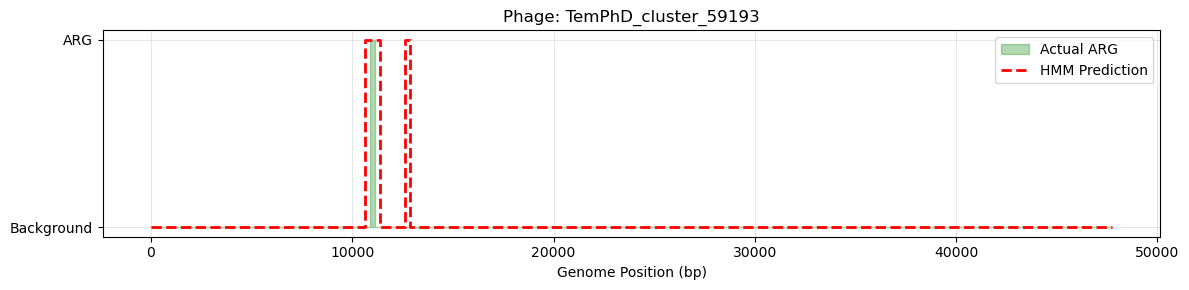

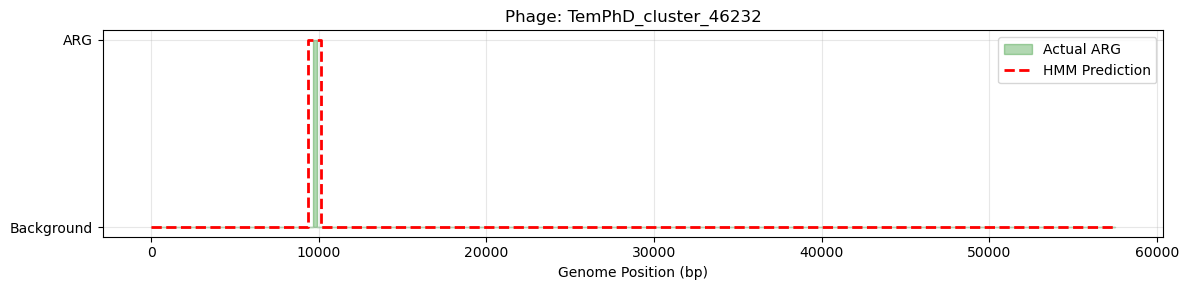

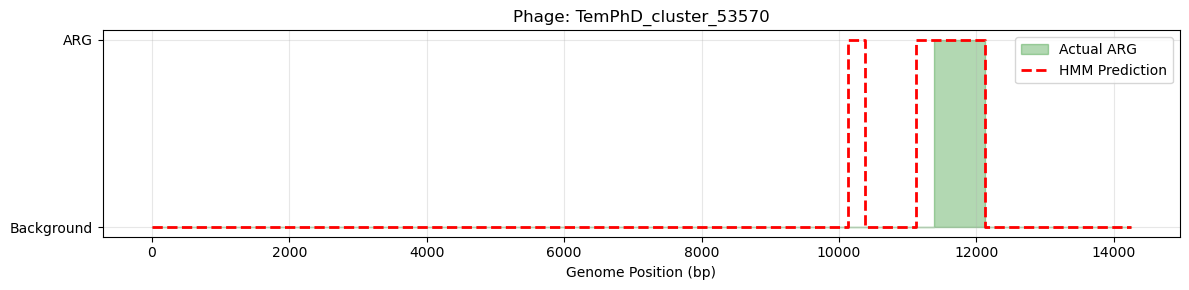

In [10]:
import numpy as np
import pandas as pd
from collections import Counter
import itertools
import warnings
import matplotlib.pyplot as plt
import random

# Sklearn & HMM Imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from hmmlearn import hmm

warnings.filterwarnings('ignore')

# ==========================================
# 1. HELPER FUNCTIONS
# ==========================================
def reverse_complement(seq):
    """Reverse complement for reverse-strand ORFs."""
    if not isinstance(seq, str):
        seq = str(seq)
    table = str.maketrans("ACGTacgt", "TGCAtgca")
    return seq.translate(table)[::-1]

def get_kmers(sequence, k=4):
    """Calculates normalized k-mer frequencies."""
    if not sequence: return {}
    sequence = sequence.upper().replace('N', '')
    if len(sequence) < k: return {}
    
    bases = ['A', 'C', 'G', 'T']
    all_kmers = [''.join(p) for p in itertools.product(bases, repeat=k)]
    
    counts = Counter([sequence[i:i+k] for i in range(len(sequence)-k+1)])
    total = sum(counts.values())
    
    if total == 0: return {k:0 for k in all_kmers}
    return {kmer: counts.get(kmer, 0)/total for kmer in all_kmers}

def get_gc(sequence):
    """Calculates GC Content."""
    if not sequence: return 0.0
    s = sequence.upper()
    return (s.count('G') + s.count('C')) / len(s)

def plot_phage_prediction(phage_id, windows, y_true, y_pred):
    """Visualizes Actual vs Predicted ARG locations for a single phage."""
    plt.figure(figsize=(12, 3))
    plt.fill_between(windows, 0, y_true, color='green', alpha=0.3, step='mid', label='Actual ARG')
    plt.step(windows, y_pred, where='mid', color='red', linestyle='--', linewidth=2, label='HMM Prediction')
    plt.title(f"Phage: {phage_id}")
    plt.xlabel("Genome Position (bp)")
    plt.yticks([0, 1], ['Background', 'ARG'])
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ==========================================
# 2. THE PIPELINE (Train/Val/Test + Visualization)
# ==========================================
def run_pipeline(folder_path, db_name="TemPhD"):
    print("--- STARTING HMM PIPELINE (PART 2: Train/Val/Test + Viz) ---")
    
    if 'DataFormat' not in globals():
        print("CRITICAL ERROR: 'DataFormat' class not found.")
        return

    data = DataFormat(folder_path, db_name)
    
    # Load data
    try:
        amr_df = data.__load_tsv__(data.amr_tsv)
        meta_df = data.__load_tsv__(data.meta_tsv)
        prot_df = data.__load_tsv__(data.protein_tsv)
    except Exception as e:
        print(f"Error loading data: {e}")
        return
    
    # Filter for valid phages
    hq_phages = meta_df[meta_df['Completeness'].isin(['High-quality', 'Complete'])]['Phage_ID'].unique()
    arg_phages = amr_df['Phage_id'].unique()
    valid_phages = list(set(hq_phages) & set(arg_phages))

    # Split
    train_val_phages, test_phages = train_test_split(valid_phages, test_size=0.15, random_state=42)
    train_phages, val_phages = train_test_split(train_val_phages, test_size=0.176, random_state=42)

    print(f"\n[CHECKPOINT 1] DATA SPLIT")
    print(f"Total Valid Phages: {len(valid_phages)}")
    print(f"Training Set:   {len(train_phages)} phages")
    print(f"Validation Set: {len(val_phages)} phages")
    print(f"Test Set:       {len(test_phages)} phages")

    # -----------------------------------------
    # 3. FEATURE EXTRACTION WITH STRAND FIX
    # -----------------------------------------
    window_size = 500
    step = 250
    k = 4
    features = []
    
    print(f"Extracting features from {len(valid_phages)} phages...")

    for idx, phage_id in enumerate(valid_phages):
        if idx % 50 == 0 and idx > 0:
            print(f"Processing... {idx}/{len(valid_phages)}")
            
        df_seq = data.__load_fasta__(phage_id)
        if df_seq is None or df_seq.empty: continue
        seq = df_seq.iloc[0]['sequence']

        my_args = amr_df[amr_df['Phage_id'] == phage_id]
        my_prots = prot_df[prot_df['Phage_ID'] == phage_id]
        arg_prot_ids = set(my_args['Protein_id'])

        # -----------------------------------------
        # FIX: Get ARG coordinates with strand handling
        # -----------------------------------------
        arg_coords = []
        for _, row in my_prots[my_prots['Protein_ID'].isin(arg_prot_ids)].iterrows():
            try:
                start = int(row['Start'])
                stop = int(row['Stop'])
                strand = str(row.get('Strand', '+'))

                if strand == "-":
                    start, stop = stop, start  # reverse direction

                arg_coords.append((start, stop))
            except:
                continue
            
        # Sliding windows
        for i in range(0, len(seq) - window_size, step):
            w_seq = seq[i:i+window_size]
            w_start, w_end = i, i + window_size
            
            # Label window
            label = 0
            for (astart, astop) in arg_coords:
                overlap = max(0, min(w_end, astop) - max(w_start, astart))
                if overlap > (window_size * 0.40):
                    label = 1
                    break
            
            row = {'Phage_ID': phage_id, 'Label': label, 'Window_Start': w_start}

            # Add k-mers + GC
            row.update(get_kmers(w_seq, k))
            row['Local_GC'] = get_gc(w_seq)

            # -----------------------------------------
            # FIX: Handle reverse-strand proteins in this window
            #-----------------------------------------
            w_prots = []

            for _, prow in my_prots.iterrows():
                try:
                    s = int(prow['Start'])
                    e = int(prow['Stop'])
                    strand = str(prow.get('Strand', '+'))
                except:
                    continue

                # Overlap check
                if s < w_end and e > w_start:

                    # extract subseq
                    subseq = seq[s:e] if s < e else seq[e:s]

                    # apply reverse complement if needed
                    if strand == "-":
                        subseq = reverse_complement(subseq)

                    new_prow = prow.copy()
                    new_prow["Seq"] = subseq
                    w_prots.append(new_prow)

            # Density
            row['Protein_Density'] = len(w_prots)

            # AA composition features
            cols_to_avg = ['Aromaticity', 'Instability_index', 'Isoelectric_point']
            for c in cols_to_avg:
                vals = pd.to_numeric([p[c] for p in w_prots], errors='coerce')
                row[c] = vals.mean() if len(vals) else 0.0

            features.append(row)

    df = pd.DataFrame(features)

    # -----------------------------------------
    # Preprocessing, PCA, HMM, Visualization unchanged
    # -----------------------------------------

    # SPLITS
    df_train = df[df['Phage_ID'].isin(train_phages)]
    df_val   = df[df['Phage_ID'].isin(val_phages)]
    df_test  = df[df['Phage_ID'].isin(test_phages)]

    print(f"\n[CHECKPOINT 2] FEATURE MATRIX SIZES")
    print(f"Train Rows: {len(df_train)} | Val Rows: {len(df_val)} | Test Rows: {len(df_test)}")

    # PREPROCESSING
    drop_cols = ['Phage_ID', 'Label', 'Window_Start']
    
    imputer = SimpleImputer(strategy='mean')
    scaler  = StandardScaler()
    pca     = PCA(n_components=50)

    # Train
    X_train = pca.fit_transform(scaler.fit_transform(imputer.fit_transform(df_train.drop(columns=drop_cols))))
    y_train = df_train['Label'].values

    # Val
    X_val = pca.transform(scaler.transform(imputer.transform(df_val.drop(columns=drop_cols))))
    y_val = df_val['Label'].values

    # Test
    X_test = pca.transform(scaler.transform(imputer.transform(df_test.drop(columns=drop_cols))))
    y_test = df_test['Label'].values

    print(f"\n[CHECKPOINT 3] PCA COMPLETE")
    print(f"Variance Explained: {np.sum(pca.explained_variance_ratio_):.4f}")

    # HMM
    X_bg  = X_train[y_train == 0]
    X_arg = X_train[y_train == 1]

    if len(X_arg) < 5:
        print("CRITICAL WARNING: Not enough ARG samples.")
        return

    model = hmm.GaussianHMM(
        n_components=2,
        covariance_type="full",
        init_params="",
        verbose=False
    )

    model.startprob_ = np.array([0.99, 0.01])
    model.transmat_  = np.array([[0.99, 0.01], 
                                 [0.10, 0.90]])

    model.means_  = np.array([X_bg.mean(axis=0), X_arg.mean(axis=0)])
    model.covars_ = np.array([
        np.cov(X_bg.T)  + np.eye(50)*0.1,
        np.cov(X_arg.T) + np.eye(50)*0.1
    ])

    print(f"\n[CHECKPOINT 4] HMM BUILT")

    # Validation
    lengths_val = df_val.groupby('Phage_ID').size().values
    y_pred_val  = model.predict(X_val, lengths_val)
    print("\n=== VALIDATION SET RESULTS ===")
    print(classification_report(y_val, y_pred_val))

    # Test
    lengths_test = df_test.groupby('Phage_ID').size().values
    y_pred_test  = model.predict(X_test, lengths_test)
    print("\n=== TEST SET RESULTS (FINAL) ===")
    print(classification_report(y_test, y_pred_test))
    print(confusion_matrix(y_test, y_pred_test))

    # Visualization
    print("\n[CHECKPOINT 5] VISUALIZING RANDOM PREDICTIONS")
    test_with_arg = df_test[df_test['Label'] == 1]['Phage_ID'].unique()
    
    if len(test_with_arg):
        for pid in random.sample(list(test_with_arg), min(3, len(test_with_arg))):
            mask = (df_test['Phage_ID'] == pid).values
            X_p = X_test[mask]
            y_true_p = df_test[mask]['Label'].values
            windows = df_test[mask]['Window_Start'].values

            y_pred_p = model.predict(X_p, [len(X_p)])
            plot_phage_prediction(pid, windows, y_true_p, y_pred_p)
    else:
        print("No ARGs in test set.")

# RUN IT
my_folder = r"C:\Users\subak\OneDrive\Documents\Comp Bio"
run_pipeline(my_folder)


--- STARTING ARG DETECTION PROGRAM (strand-aware) ---

[CHECKPOINT 1] DATASET PREPARATION
Total Valid Phages: 328
Training Set: 262 | Test Set: 66
--------------------------------------------------
Extracting k-mer features from 328 phages...
Processing... 50/328
Processing... 100/328
Processing... 150/328
Processing... 200/328
Processing... 250/328
Processing... 300/328

[CHECKPOINT 2] DIMENSIONALITY REDUCTION COMPLETE
PCA Variance Explained: 0.6139
--------------------------------------------------

[CHECKPOINT 3] MODEL TRAINED (Supervised Initialization + Regularization)

=== EVALUATION ON TEST DATASET ===
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00     14802
         ARG       0.76      0.90      0.82       224

    accuracy                           0.99     15026
   macro avg       0.88      0.95      0.91     15026
weighted avg       0.99      0.99      0.99     15026

Confusion Matrix:
[[14737    65]
 [   22   202]]

[CHECK

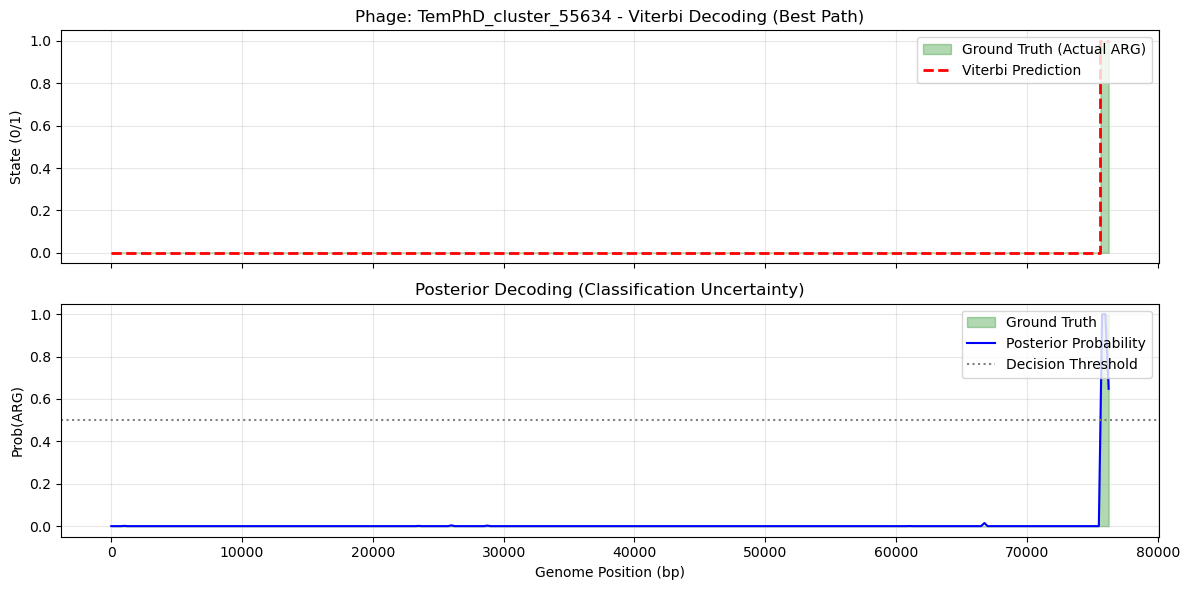

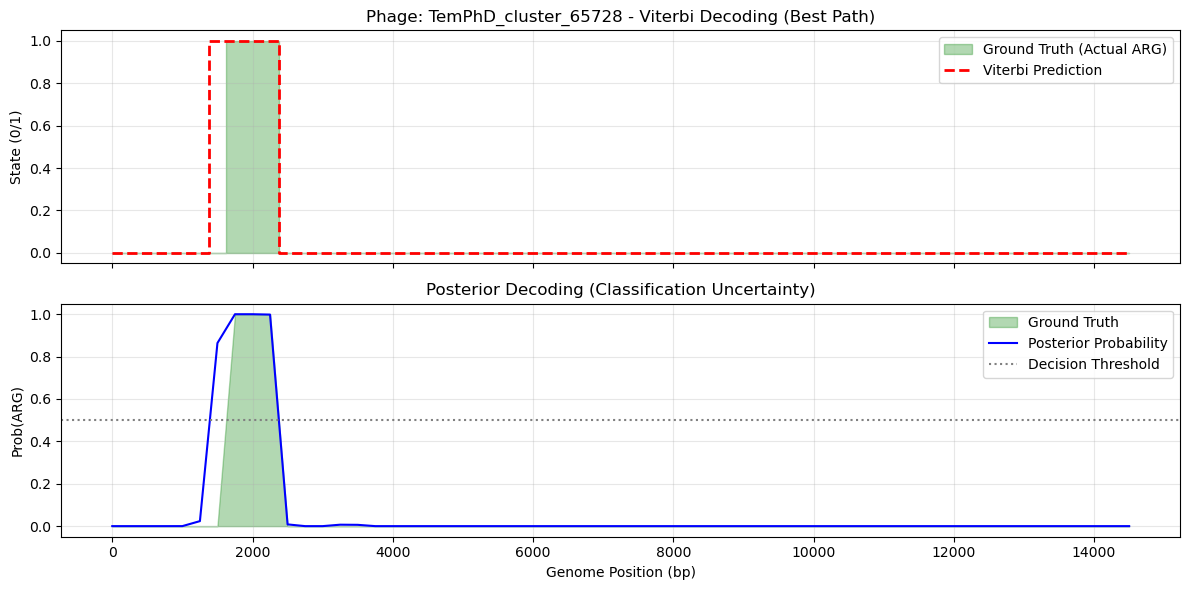

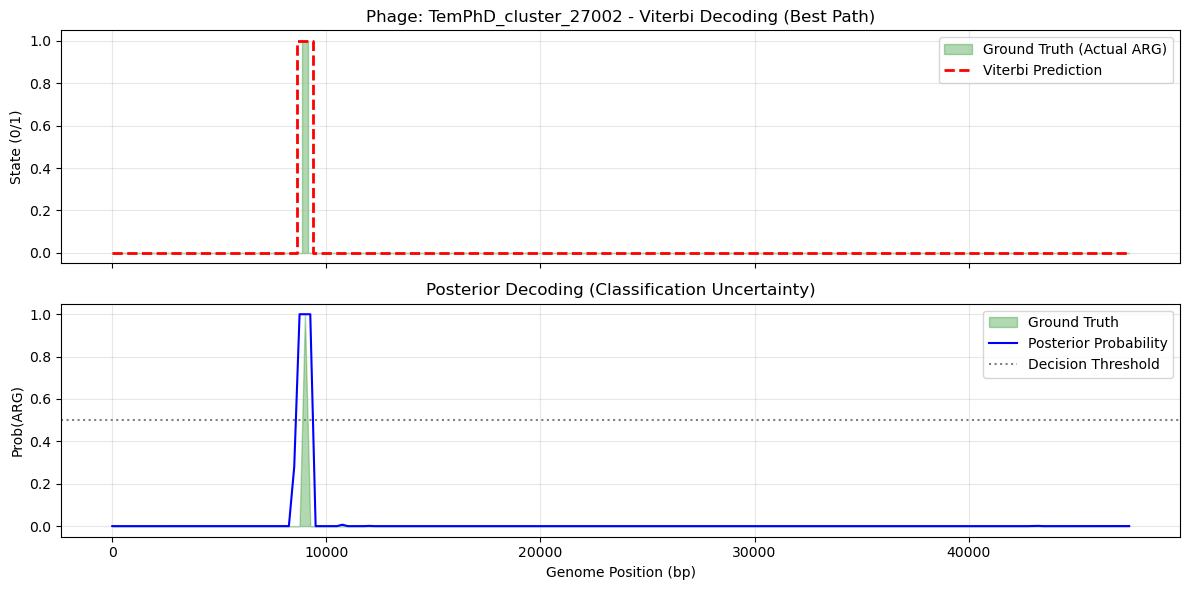

In [11]:
import numpy as np
import pandas as pd
from collections import Counter
import itertools
import warnings
import matplotlib.pyplot as plt
import random

# Sklearn & HMM Imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from hmmlearn import hmm

warnings.filterwarnings('ignore')

# ==========================================
# 1. HELPER FUNCTIONS
# ==========================================
def reverse_complement(seq):
    """Return reverse complement of a DNA sequence."""
    if seq is None:
        return None
    seq = str(seq)
    comp = str.maketrans("ACGTacgt", "TGCAtgca")
    return seq.translate(comp)[::-1]

def get_kmers(sequence, k=4):
    """Calculates normalized k-mer frequencies."""
    if not sequence:
        return {}
    sequence = sequence.upper().replace('N', '')
    if len(sequence) < k:
        return {}
    
    bases = ['A', 'C', 'G', 'T']
    all_kmers = [''.join(p) for p in itertools.product(bases, repeat=k)]
    
    counts = Counter([sequence[i:i+k] for i in range(len(sequence)-k+1)])
    total = sum(counts.values())
    
    if total == 0:
        return {kmer: 0 for kmer in all_kmers}
    return {kmer: counts.get(kmer, 0)/total for kmer in all_kmers}

def get_gc(sequence):
    """Calculates GC Content."""
    if not sequence:
        return 0.0
    s = sequence.upper()
    return (s.count('G') + s.count('C')) / len(s)

def visualize_decoding(phage_id, windows, y_true, y_pred_viterbi, y_prob_posterior):
    """
    Visualizes Viterbi (Best Path) vs Posterior (Uncertainty).
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    
    # Plot 1: Viterbi (Binary Decision)
    ax1.fill_between(windows, 0, y_true, color='green', alpha=0.3, step='mid', label='Ground Truth (Actual ARG)')
    ax1.step(windows, y_pred_viterbi, where='mid', color='red', linestyle='--', linewidth=2, label='Viterbi Prediction')
    ax1.set_ylabel("State (0/1)")
    ax1.set_title(f"Phage: {phage_id} - Viterbi Decoding (Best Path)")
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Posterior (Confidence/Uncertainty)
    ax2.fill_between(windows, 0, y_true, color='green', alpha=0.3, label='Ground Truth')
    ax2.plot(windows, y_prob_posterior, color='blue', linewidth=1.5, label='Posterior Probability')
    ax2.axhline(y=0.5, color='gray', linestyle=':', label='Decision Threshold')
    ax2.set_ylabel("Prob(ARG)")
    ax2.set_xlabel("Genome Position (bp)")
    ax2.set_title("Posterior Decoding (Classification Uncertainty)")
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ==========================================
# 2. MAIN PROGRAM (strand-aware patch)
# ==========================================
def run_pipeline(folder_path, db_name="TemPhD"):
    print("--- STARTING ARG DETECTION PROGRAM (strand-aware) ---")
    
    # 1. SETUP: Detect DataFormat Class
    if 'DataFormat' not in globals():
        print("CRITICAL ERROR: 'DataFormat' class not found. Please run Part 1 code first.")
        return

    data = DataFormat(folder_path, db_name)
    
    try:
        amr_df = data.__load_tsv__(data.amr_tsv)
        meta_df = data.__load_tsv__(data.meta_tsv)
        prot_df = data.__load_tsv__(data.protein_tsv)
    except AttributeError:
        print("Error: Could not find '__load_tsv__'. Ensure Part 1 code is loaded.")
        return
    except Exception as e:
        print(f"Error loading data: {e}")
        return
    
    # Ensure Strand column exists and normalize
    if 'Strand' in prot_df.columns:
        prot_df['Strand'] = prot_df['Strand'].astype(str).str.strip()
    elif 'strand' in prot_df.columns:
        prot_df['Strand'] = prot_df['strand'].astype(str).str.strip()
    else:
        # If no strand column, create placeholder '+' (best-effort fallback)
        prot_df['Strand'] = '+'
        print("WARNING: No 'Strand' column found in protein metadata — assuming '+' for all proteins.")
    
    # 2. DATA FILTERING (High Quality & Complete)
    hq_phages = meta_df[meta_df['Completeness'].isin(['High-quality', 'Complete'])]['Phage_ID'].unique()
    arg_phages = amr_df['Phage_id'].unique()
    valid_phages = list(set(hq_phages) & set(arg_phages))
    
    # 3. SPLIT: 80% Train, 20% Test (Evaluation Dataset)
    train_phages, test_phages = train_test_split(valid_phages, test_size=0.20, random_state=42)

    print(f"\n[CHECKPOINT 1] DATASET PREPARATION")
    print(f"Total Valid Phages: {len(valid_phages)}")
    print(f"Training Set: {len(train_phages)} | Test Set: {len(test_phages)}")
    print("--------------------------------------------------")

    # 4. FEATURE EXTRACTION
    window_size = 500
    step = 250
    k = 4
    features = []
    
    print(f"Extracting k-mer features from {len(valid_phages)} phages...")
    for idx, phage_id in enumerate(valid_phages):
        if idx % 50 == 0 and idx > 0:
            print(f"Processing... {idx}/{len(valid_phages)}")
            
        df_seq = data.__load_fasta__(phage_id)
        if df_seq is None or df_seq.empty:
            continue
        seq = df_seq.iloc[0]['sequence']
        seq_len = len(seq)
        
        my_args = amr_df[amr_df['Phage_id'] == phage_id]
        my_prots = prot_df[prot_df['Phage_ID'] == phage_id].copy()
        arg_prot_ids = set(my_args['Protein_id'])
        
        # Prepare ARG coordinates (convert to 0-based slicing coords for overlap checks)
        arg_coords = []
        for _, row in my_prots[my_prots['Protein_ID'].isin(arg_prot_ids)].iterrows():
            try:
                s = int(row['Start'])
                e = int(row['Stop'])
                # Convert to 0-based inclusive/exclusive slicing: [s-1:e]
                s0 = max(0, s - 1)
                e0 = min(seq_len, e)
                arg_coords.append((s0, e0))
            except:
                continue
            
        for i in range(0, max(1, seq_len - window_size + 1), step):
            w_seq = seq[i:i+window_size]
            w_start, w_end = i, min(i + window_size, seq_len)
            
            # Label window by ARG overlap (using 0-based coords)
            label = 0 
            for (astart, astop) in arg_coords:
                overlap = max(0, min(w_end, astop) - max(w_start, astart))
                if overlap > (window_size * 0.40):
                    label = 1
                    break
            
            row = {'Phage_ID': phage_id, 'Label': label, 'Window_Start': w_start}
            row.update(get_kmers(w_seq, k))
            row['Local_GC'] = get_gc(w_seq)
            
            # Find proteins overlapping this window (using 0-based conversion)
            # original proto coords are likely 1-based, convert to 0-based slicing [start-1:stop]
            overlaps = []
            for _, prow in my_prots.iterrows():
                try:
                    ps = int(prow['Start'])
                    pe = int(prow['Stop'])
                except:
                    continue
                ps0 = max(0, ps - 1)
                pe0 = min(seq_len, pe)
                if ps0 < w_end and pe0 > w_start:
                    overlaps.append(prow)
            if len(overlaps) > 0:
                overlapped_prots = pd.DataFrame(overlaps)
            else:
                overlapped_prots = pd.DataFrame(columns=my_prots.columns)
            
            # Strand-aware extraction: get nucleotide subseq for overlapping proteins (RC if needed)
            orf_seqs = []
            for _, op in overlapped_prots.iterrows():
                try:
                    ps = int(op['Start'])
                    pe = int(op['Stop'])
                except:
                    continue
                ps0 = max(0, ps - 1)
                pe0 = min(seq_len, pe)
                if ps0 >= pe0:
                    # try swapped coordinates if present (defensive)
                    ps0, pe0 = min(ps0, pe0), max(ps0, pe0)
                subseq = seq[ps0:pe0]
                strand = str(op.get('Strand', '+')).strip()
                if strand == '-' or strand == '-1':
                    subseq = reverse_complement(subseq)
                orf_seqs.append(subseq)
            
            # Protein density = number of overlapping ORFs (strand-corrected subseqs considered)
            row['Protein_Density'] = len(orf_seqs)
            
            # Average protein-level numeric features (if present)
            cols = ['Aromaticity', 'Instability_index', 'Isoelectric_point']
            for c in cols:
                if c in overlapped_prots.columns and len(overlapped_prots) > 0:
                    vals = pd.to_numeric(overlapped_prots[c], errors='coerce').dropna()
                    row[c] = vals.mean() if len(vals) > 0 else 0.0
                else:
                    row[c] = 0.0 
                
            features.append(row)

    df = pd.DataFrame(features)
    
    # Split Feature Matrix
    df_train = df[df['Phage_ID'].isin(train_phages)]
    df_test = df[df['Phage_ID'].isin(test_phages)]

    # 5. PREPROCESSING (PCA)
    drop_cols = ['Phage_ID', 'Label', 'Window_Start']
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
    n_components = 50
    pca = PCA(n_components=n_components)
    
    # Train Fit
    X_train = pca.fit_transform(scaler.fit_transform(imputer.fit_transform(df_train.drop(columns=drop_cols))))
    y_train = df_train['Label'].values
    
    # Test Transform
    X_test = pca.transform(scaler.transform(imputer.transform(df_test.drop(columns=drop_cols))))
    y_test = df_test['Label'].values

    print(f"\n[CHECKPOINT 2] DIMENSIONALITY REDUCTION COMPLETE")
    print(f"PCA Variance Explained: {np.sum(pca.explained_variance_ratio_):.4f}")
    print("--------------------------------------------------")

    # 6. HMM TRAINING (Addressing Initialization Pitfalls)
    # We use Supervised MLE Initialization to avoid local optima common in Baum-Welch
    X_bg = X_train[y_train == 0]
    X_arg = X_train[y_train == 1]
    
    if len(X_arg) < 5:
        print("CRITICAL WARNING: not enough ARG examples in training; aborting.")
        return

    model = hmm.GaussianHMM(n_components=2, covariance_type="full", init_params="", verbose=False)
    
    # Initialization (Avoids sensitivity to random starts)
    model.startprob_ = np.array([0.99, 0.01])
    model.transmat_ = np.array([[0.99, 0.01], [0.10, 0.90]])
    model.means_ = np.array([X_bg.mean(axis=0), X_arg.mean(axis=0)])
    
    # Regularization (Diagonal Loading to prevent overfitting)
    cov_bg = np.cov(X_bg.T) + np.eye(n_components) * 0.1
    cov_arg = np.cov(X_arg.T) + np.eye(n_components) * 0.1
    model.covars_ = np.array([cov_bg, cov_arg])
    model.n_features = n_components
    
    print(f"\n[CHECKPOINT 3] MODEL TRAINED (Supervised Initialization + Regularization)")

    # 7. EVALUATION (Viterbi Decoding on Test Set)
    lengths_test = df_test.groupby('Phage_ID').size().values
    y_pred_viterbi = model.predict(X_test, lengths_test)
    
    print("\n=== EVALUATION ON TEST DATASET ===")
    print(classification_report(y_test, y_pred_viterbi, target_names=['Background', 'ARG']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_viterbi))
    
    # 8. POSTERIOR DECODING & VISUALIZATION
    print("\n[CHECKPOINT 4] VISUALIZING POSTERIOR DECODING (Uncertainty Analysis)")
    
    test_phages_with_arg = df_test[df_test['Label'] == 1]['Phage_ID'].unique()
    
    if len(test_phages_with_arg) > 0:
        sample_count = min(3, len(test_phages_with_arg))
        viz_phages = random.sample(list(test_phages_with_arg), sample_count)
        
        for pid in viz_phages:
            mask = (df_test['Phage_ID'] == pid).values
            X_p = X_test[mask]
            windows = df_test[mask]['Window_Start'].values
            y_true_p = df_test[mask]['Label'].values
            
            # Viterbi (Best Path)
            y_vit = model.predict(X_p, [len(X_p)])
            
            # Posterior (Probabilities) - state 1 probability
            try:
                y_post = model.predict_proba(X_p, [len(X_p)])[:, 1]
            except Exception:
                # Fallback if predict_proba not available
                y_post = np.zeros(len(X_p))
            
            visualize_decoding(pid, windows, y_true_p, y_vit, y_post)
    else:
        print("No ARGs found in Test Set to visualize.")

# RUN IT
my_folder = r"C:\Users\subak\OneDrive\Documents\Comp Bio"
run_pipeline(my_folder)
